In [1]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import json
from utils.rouge import RougeL
from utils.precision_recall_f1 import precision_recall_f1
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
ans_pattern = re.compile(r'@content\d@')

def find_answer_in_docid(answer):
    docs = ans_pattern.findall(answer)
    return list(set([int(doc[-2:-1]) for doc in docs]))

def find_best_match_index(sub_text, content):
    """
    找到 sub_text 在 content 覆盖度最大的开始和结束下标
    """
    if sub_text in content:
        best_start = content.index(sub_text)
        best_end = best_start + len(sub_text)
        return best_start, best_end, 1
    elif sub_text.endswith('。') and sub_text[:-1] in content:
        best_start = content.index(sub_text[:-1])
        best_end = best_start + len(sub_text)
        return best_start, best_end, 1
    else:
        # 不能直接定位，利用覆盖率搜索
        best_recall = 0
        best_start = -1
        best_end = -1
        for start_idx in range(0, len(content)):
            if content not in sub_text:
                continue

            for end_idx in range(len(content) - 1, start_idx - 1, -1):
                if content[end_idx] not in sub_text:
                    continue

                sub_para_content = content[start_idx: end_idx + 1]
                recall = precision_recall_f1(sub_para_content, sub_text)[1]

                if recall >= best_recall:
                    best_recall = recall
                    best_start = start_idx
                    best_end = end_idx

        if best_recall == 0:
            return -1, -1, 0
        else:
            rougel = RougeL().add_inst(cand=content[best_start: best_end + 1], ref=sub_text).get_score()
            return best_start, best_end + 1, rougel


In [3]:
def gen_trainable_dataset(sample):
    for doc in sample['documents']:
        if 'content' not in doc:
            doc['content'] = ''.join(doc['paragraphs'])

    # 修复清洗过程 @content@@content@ 被破坏的 bug
    sample['supporting_paragraph'] = sample['supporting_paragraph'].replace('@content1@content', '@content1@@content'). \
        replace('@content2@content', '@content2@@content').replace('@content3@content', '@content3@@content'). \
        replace('@content4@content', '@content4@@content').replace('@content5@content', '@content5@@content')

    # 相聚 support paragraph 找到答案所在的 sub para
    support_para_in_docids = find_answer_in_docid(sample['supporting_paragraph'])

    supported_paras = {}
    for sup_para_in_docid in support_para_in_docids:
        para_strs = sample['supporting_paragraph'].split('@content{}@'.format(sup_para_in_docid))
        for para_str in para_strs:
            if para_str != '' and '@content' not in para_str:
                sup_start, sup_end, rougel = find_best_match_index(para_str, sample['documents'][sup_para_in_docid - 1]['content'])
                # 同一个 doc 可能出现多个support para
                if sup_para_in_docid in supported_paras:
                    supported_paras[sup_para_in_docid].append((para_str, sup_start, sup_end))
                supported_paras[sup_para_in_docid] = [(para_str, sup_start, sup_end)]

    answer = sample['answer']
    ans_in_docids = find_answer_in_docid(answer)
    answer_texts = []
    # 可能存在跨 doc 的答案（dureader中表现为多答案的形式）
    answer_labels = []
    for ans_in_docid in ans_in_docids:
        # 找到当前 doc 的支撑para信息，这些para中可能包含答案
        doc_support_paras = supported_paras[ans_in_docid]

        # IMPORTANT:
        # 答案几乎都在 supporting_paragraph 中，所以进行答案定位的时候，需要先根据 supporting_paragraph 缩小答案的搜索范围，
        # 再在其中定位答案的实际开始和结束的下标，同时需要注意加上 supporting_paragraph 搜索下标的偏移 shifted_start
        answer_strs = answer.split('@content{}@'.format(ans_in_docid))
        for answer_str in answer_strs:
            answer_str = answer_str.strip()  # important
            # @content1@ 包裹的实际答案文本
            if answer_str != '' and '@content' not in answer_str:
                answer_texts.append(answer_str)

                max_rougel = 0
                best_start_in_sup_para = -1
                best_end_in_sup_para = -1
                best_sup_para_i = None
                for sup_para_i, doc_support_para in enumerate(doc_support_paras):
                    start_in_sup_para, end_in_sup_para, rougel = find_best_match_index(answer_str, doc_support_para[0])
                    if rougel > max_rougel:
                        best_start_in_sup_para = start_in_sup_para
                        best_end_in_sup_para = end_in_sup_para
                        best_sup_para_i = sup_para_i

                if best_start_in_sup_para != -1 and best_end_in_sup_para != -1:
                    start_label = best_start_in_sup_para + doc_support_paras[best_sup_para_i][1]
                    end_label = start_label + (best_end_in_sup_para - best_start_in_sup_para)
                    answer_labels.append((ans_in_docid - 1, start_label, end_label))

        sample['answer_labels'] = answer_labels
        # 计算抽取的 fake answer 以及对应的 ceil rougel
        fake_answers = [sample['documents'][answer_label[0]]['content'][answer_label[1]: answer_label[2]]
                        for answer_label in answer_labels]
        sample['fake_answers'] = fake_answers
        ceil_rougel = RougeL().add_inst(cand=''.join(fake_answers), ref=''.join(answer_texts)).get_score()
        sample['ceil_rougel'] = ceil_rougel

In [14]:
def check_answer_in_content_coverage(operation, print_error_sample=False):
    """
    检测不同操作后，答案在篇章中的样本的覆盖率
    """
    sample_ceil_rougels = {}
    for i in range(10):
        path = '../input/{}/split_train_0{}'.format(operation, i)
        if not os.path.isfile(path):
            continue
        
        with open(path) as f:
            for line in f:
                sample = json.loads(line.strip())
                gen_trainable_dataset(sample)
                sample_ceil_rougels[sample['question_id']] = sample['ceil_rougel']
                
    return sample_ceil_rougels

In [5]:
def check_coverage(operation):
    ceil_rougels = check_answer_in_content_coverage(operation)
    ceil_rougels_arr = np.array(list(ceil_rougels.values()))
    print('ceil rougel = 0:', ceil_rougels_arr[ceil_rougels_arr != 1].shape[0] / ceil_rougels_arr.shape[0])
    print('ceil rougel = 1:', ceil_rougels_arr[ceil_rougels_arr == 1].shape[0] / ceil_rougels_arr.shape[0])
    sns.kdeplot(ceil_rougels_arr)
    plt.title('ceil rougel of raw sample')
    plt.show()
    return ceil_rougels

## 原始样本中，答案在篇章中的覆盖率

ceil rougel = 0: 0.19776194501469227
ceil rougel = 1: 0.8022380549853078


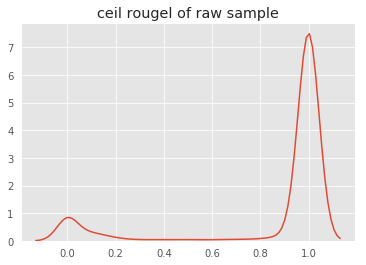

In [6]:
ceil_rougels = check_coverage('raw')

## After text cleaning

ceil rougel = 0: 0.1940989413516886
ceil rougel = 1: 0.8059010586483114


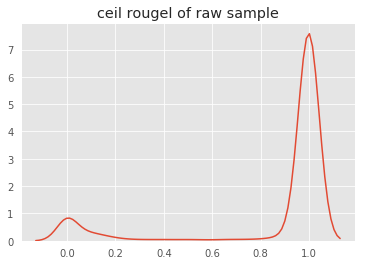

In [7]:
ceil_rougels = check_coverage('cleaned2')

## After para balance

ceil rougel = 0: 0.3221028056192891
ceil rougel = 1: 0.6778971943807108


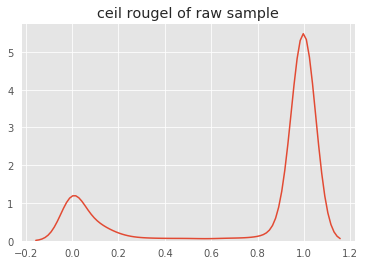

In [8]:
ceil_rougels = check_coverage('para_balance')

## After extract paragraph

ceil rougel = 0: 0.33623153403373185
ceil rougel = 1: 0.6637684659662682


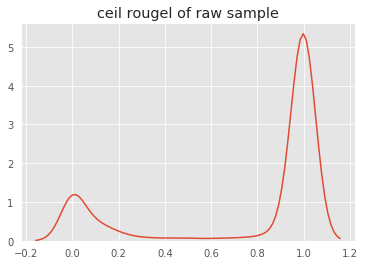

In [9]:
ceil_rougels = check_coverage('extracted')

## Final mrc dataset

ceil rougel = 0: 0.33623153403373185
ceil rougel = 1: 0.6637684659662682


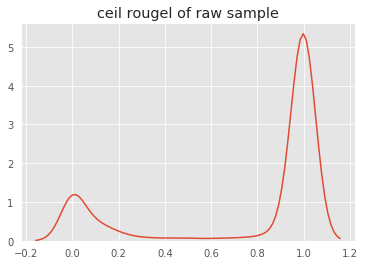

In [13]:
ceil_rougels = check_coverage('mrc_dataset')